In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf
import scipy
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from ect_plotting_functions import plot_feature_prepost

from statsmodels.formula.api import ols

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/quirine/opt/anaconda3/envs/ECT_Hadas/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/quirine/opt/anaconda3/envs/ECT_Hadas/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post ECT.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [3]:
FRONTAL_ONLY = True

In [4]:
# load dataframe
exp_df = pd.read_csv('../saved_files/ect_files/ect_all_features_appeal_3s.csv', index_col = 0)
# Exclude channels flagged as bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

In [5]:
frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]

### Load fooof fits and correct for excluded ones

In [6]:
fits_pre = np.load('../saved_files/ect_files/fits_pre_appeal_3s.npy')
fits_post = np.load('../saved_files/ect_files/fits_post_appeal_3s.npy')
freq_axis = np.load('../saved_files/ect_files/freq_axis_appeal_3s.npy')

In [7]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

### Load PSD and correct for excluded ones

In [8]:
psd_pre = np.load('../saved_files/ect_files/pre_ect_psd_appeal_3s.npy')
psd_post = np.load('../saved_files/ect_files/post_ect_psd_appeal_3s.npy')

In [9]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

## Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV.

In [10]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
60,3,pre,FP1,NaN,NaN,0.000000,-12.267606,6.962120,1.000000,0.305205,-12.236781,10.415603,1.566453,0.856319,-11.796623,-12.175244,0.263405,0.034298,0.963706,False
61,3,pre,FPZ,NaN,NaN,0.000000,-12.272245,6.964903,1.000000,0.304622,-12.235464,10.426363,1.535298,0.851369,-11.797832,-12.182917,0.253555,0.033938,0.964036,False
62,3,pre,FP2,NaN,NaN,0.000000,-12.249414,6.940363,1.000000,0.241165,-12.244837,10.405265,1.588668,0.848909,-11.794655,-12.162900,0.248060,0.035731,0.956344,False
63,3,pre,AF3,NaN,NaN,0.000000,-12.065961,6.975710,1.000000,0.279689,-12.113183,10.406530,1.377034,0.688391,-11.783610,-11.977205,0.311218,0.034778,0.947780,False
64,3,pre,AF4,NaN,NaN,0.000000,-12.066338,6.915939,1.000000,0.266846,-12.067253,10.402963,1.387491,0.645140,-11.768251,-11.978733,0.268926,0.030768,0.953309,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,55,post,C1,NaN,NaN,0.000000,-10.428589,4.407758,2.783407,0.770144,-10.798968,8.364428,5.824634,0.654967,-11.488644,-9.951242,2.244894,0.121829,0.976433,False
2727,55,post,CZ,2.727103,1.016077,0.604080,-10.360934,5.058219,1.785028,0.902219,-10.713623,8.545021,4.488725,0.674573,-11.408040,-9.885418,2.220334,0.093044,0.985013,False
2728,55,post,C2,NaN,NaN,0.000000,-10.417643,4.324318,2.721091,0.806636,-10.817033,8.438148,6.087944,0.661165,-11.518944,-9.949232,2.298567,0.129044,0.975367,False
2729,55,post,C4,3.872480,2.540675,0.850011,-10.307605,NaN,NaN,0.000000,-10.787271,8.004182,5.111284,0.605214,-11.552158,-9.957640,2.209323,0.107036,0.981238,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

In [11]:
df_include_nonan.head()

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
60,3,pre,FP1,NaN,NaN,0.0,-12.267606,6.962120,1.0,0.305205,-12.236781,10.415603,1.566453,0.856319,-11.796623,-12.175244,0.263405,0.034298,0.963706,False
61,3,pre,FPZ,NaN,NaN,0.0,-12.272245,6.964903,1.0,0.304622,-12.235464,10.426363,1.535298,0.851369,-11.797832,-12.182917,0.253555,0.033938,0.964036,False
62,3,pre,FP2,NaN,NaN,0.0,-12.249414,6.940363,1.0,0.241165,-12.244837,10.405265,1.588668,0.848909,-11.794655,-12.162900,0.248060,0.035731,0.956344,False
63,3,pre,AF3,NaN,NaN,0.0,-12.065961,6.975710,1.0,0.279689,-12.113183,10.406530,1.377034,0.688391,-11.783610,-11.977205,0.311218,0.034778,0.947780,False
64,3,pre,AF4,NaN,NaN,0.0,-12.066338,6.915939,1.0,0.266846,-12.067253,10.402963,1.387491,0.645140,-11.768251,-11.978733,0.268926,0.030768,0.953309,False


**First, average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Then, average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

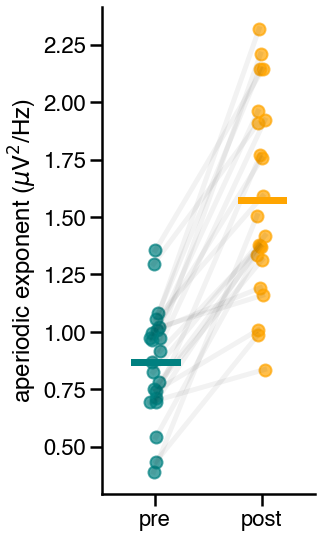

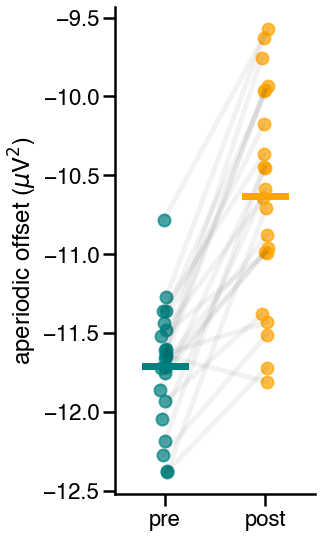

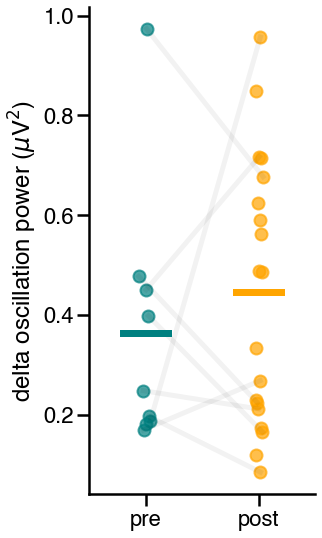

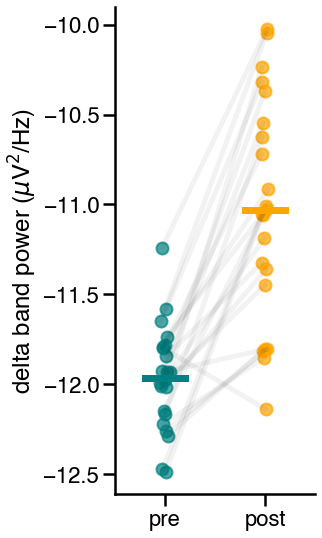

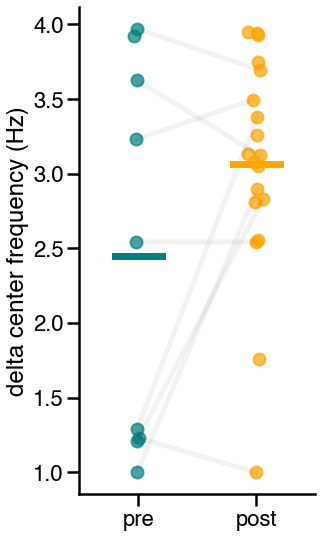

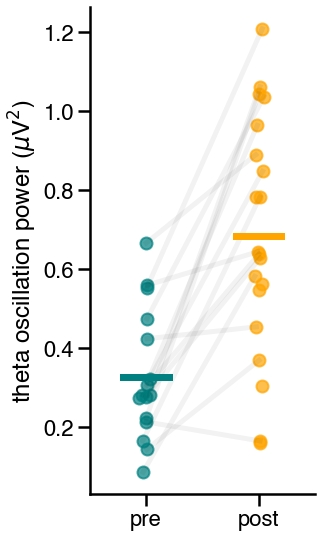

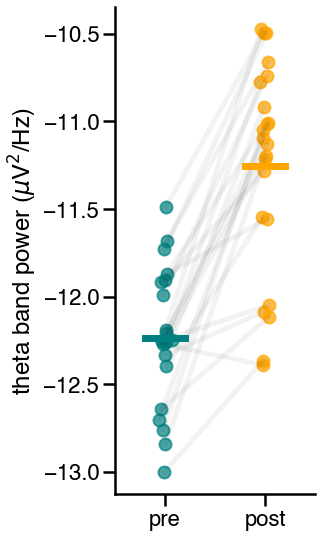

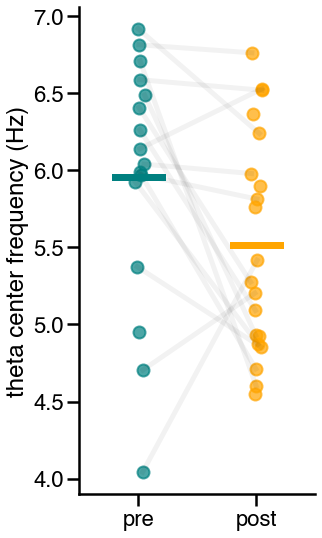

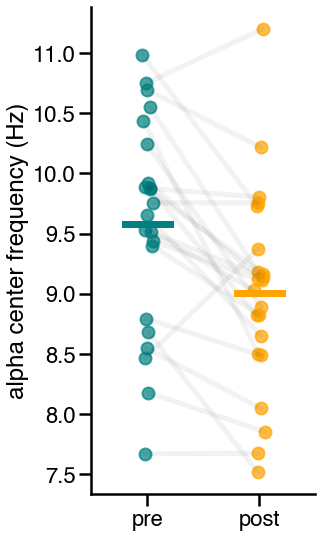

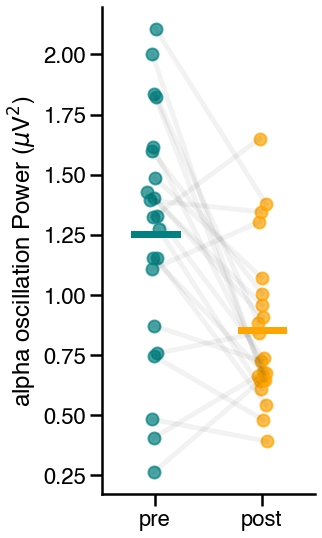

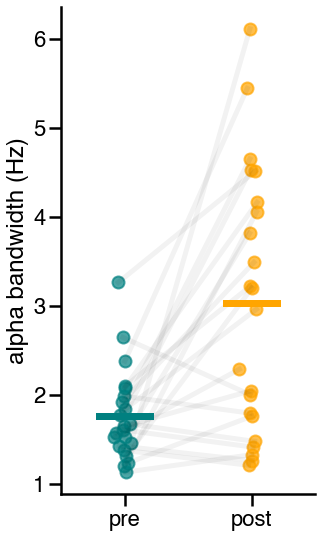

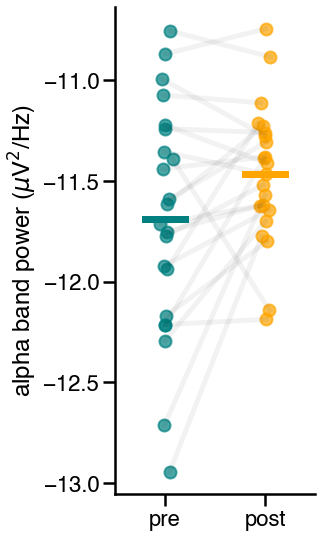

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bw', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation Power ($\mu$V$^2$)',
          'alpha bandwidth (Hz)', 'alpha band power ($\mu$V$^2$/Hz)' ]



for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

## Power spectra & fooof fits

In [15]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


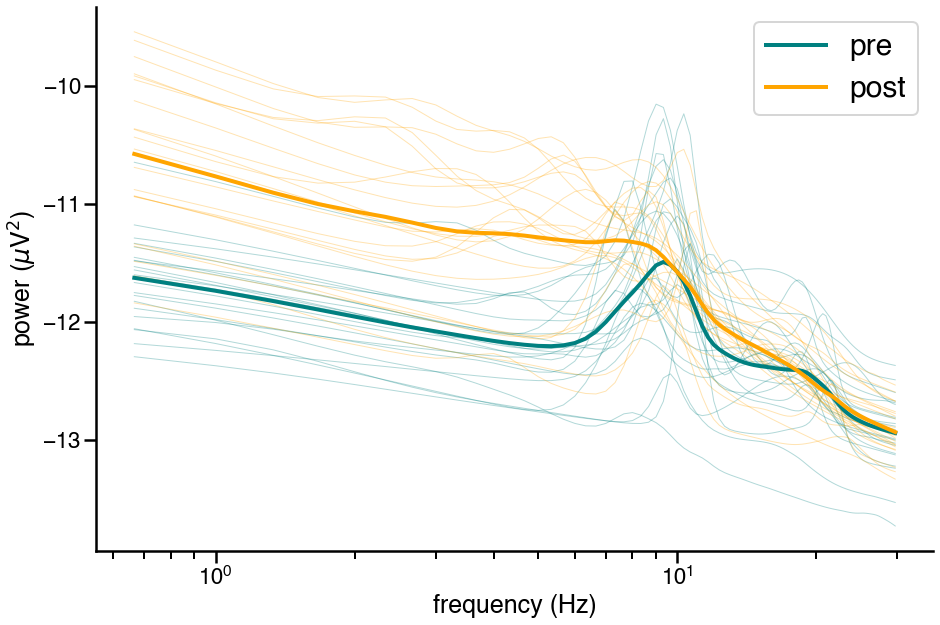

<Figure size 432x288 with 0 Axes>

In [17]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:90], fits_pre_mean[patient], color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:90], fits_post_mean[patient], color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:90], fits_pre_grand_mean, color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:90], fits_post_grand_mean, color='orange', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})

sns.despine()
plt.show()
plt.savefig(fig_path+'ect_spectra_fits_appeal_3s.pdf', format='pdf')

In [18]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


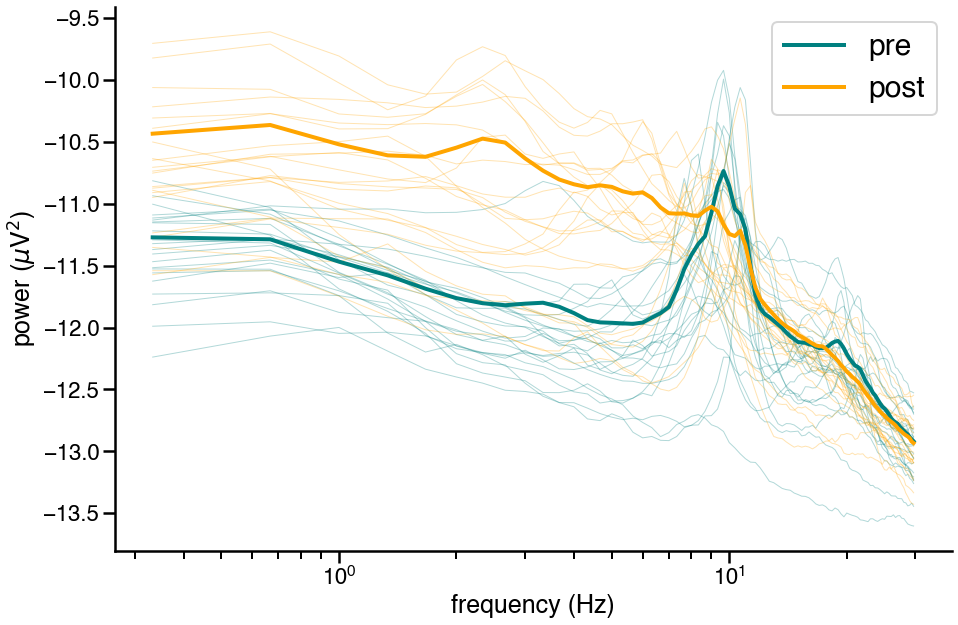

In [20]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[1:90], np.log10(psd_pre_mean[patient,1:90]), color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[1:90], np.log10(psd_post_mean[patient,1:90]), color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[1:90], np.log10(psd_pre_grand_mean[1:90]), color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[1:90], np.log10(psd_post_grand_mean[1:90]), color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Descriptive statistics

## Statistics!

### Exponent: Pre/Post

**Normality**

In [21]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.971403  0.74331    True
          W      pval  normal
0  0.958658  0.462645    True


**Distribution of means pre vs. post**

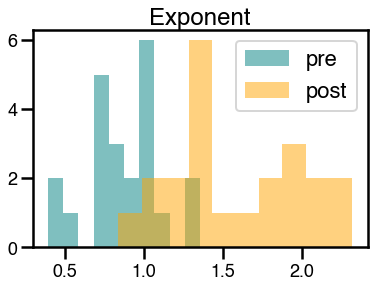

In [22]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [23]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative         p-val  RBC     CLES
Wilcoxon    0.0   two-sided  4.768372e-07 -1.0  0.06405
               T  dof alternative         p-val           CI95%  cohen-d  \
T-test -9.431478   21   two-sided  5.345212e-09  [-0.86, -0.55]  2.02367   

            BF10  power  
T-test  2.28e+06    1.0  


### Delta Oscillatory Power: Pre/Post

**Normality**

In [24]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.764218  0.007921   False
          W      pval  normal
0  0.932434  0.192001    True


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs.

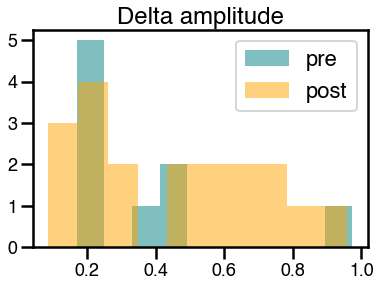

In [25]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [26]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   16.0   two-sided  0.84375  0.111111  0.515625
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.202751    7   two-sided  0.845097  [-0.32, 0.27]  0.086355  0.342   

           power  
T-test  0.055202  


### Delta Band Power: Pre/Post

**Normality**

In [27]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.974014  0.801704    True
          W      pval  normal
0  0.960149  0.492298    True


#### Distribution of means pre vs. post

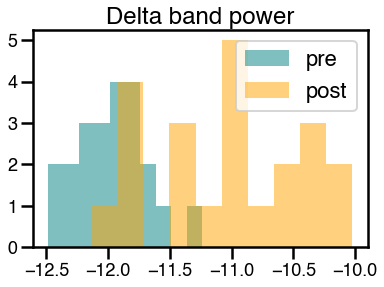

In [28]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [29]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    2.0   two-sided  0.000001 -0.98419  0.097107
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.009246   21   two-sided  8.084148e-08  [-1.18, -0.69]  1.918284   

             BF10  power  
T-test  1.825e+05    1.0  


### Delta center frequency: pre/post

**Normality**

In [30]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.833827  0.049287   False
          W      pval  normal
0  0.895128  0.039748   False


#### Distribution of means pre vs. post

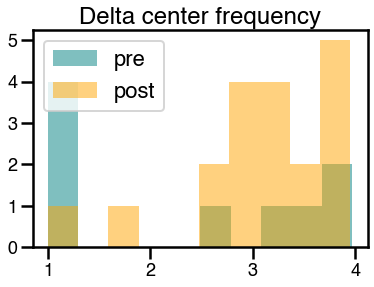

In [31]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [32]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC   CLES
Wilcoxon   11.0   two-sided  0.382812 -0.388889  0.375
              T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -1.60091    7   two-sided  0.15343  [-1.51, 0.29]  0.577897  0.847   

           power  
T-test  0.293136  


### Theta oscillatory power: pre/post

**Normality**

In [33]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.93647  0.308001    True
          W      pval  normal
0  0.969157  0.736989    True


#### Distribution of means pre vs. post

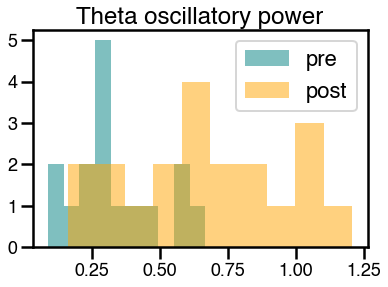

In [34]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

In [35]:
# Wait do we actually need to get rid of the NaNs?? 

In [36]:
# find indices of nans in pre and post
nan_pre = np.squeeze(np.where(np.isnan(means_pre)))
nan_post = np.squeeze(np.where(np.isnan(means_post)))
nan_total = np.unique(np.append(nan_pre, nan_post))

# delete nans from pre and post
means_pre = np.delete(means_pre, nan_total, axis=0)
means_post = np.delete(means_post, nan_total, axis=0)

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [37]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    2.0   two-sided  0.000183 -0.966667  0.115556
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -5.937827   14   two-sided  0.000036  [-0.57, -0.27]  1.772064   

           BF10     power  
T-test  702.178  0.999994  


### Theta bandpower: pre/post

**Normality**

In [38]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.966229  0.624138    True
          W      pval  normal
0  0.911427  0.050627    True


#### Distribution of means pre vs. post

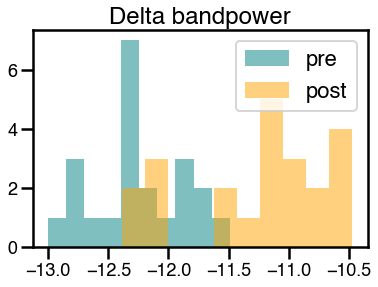

In [39]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta bandpower')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [40]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative         p-val       RBC      CLES
Wilcoxon    1.0   two-sided  9.536743e-07 -0.992095  0.113636
               T  dof alternative         p-val           CI95%  cohen-d  \
T-test -8.720256   21   two-sided  2.012425e-08  [-1.21, -0.75]    1.926   

             BF10  power  
T-test  6.634e+05    1.0  


### Theta center frequency: pre/post

**Normality**

In [41]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.897393  0.073013    True
          W      pval  normal
0  0.927274  0.136832    True


#### Distribution of means pre vs. post

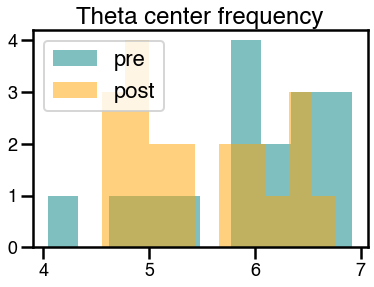

In [42]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [43]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative    p-val  RBC      CLES
Wilcoxon   24.0   two-sided  0.04126  0.6  0.693333
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.158553   14   two-sided  0.048734  [0.0, 1.01]  0.664227  1.568   

           power  
T-test  0.667689  


### Alpha oscillatory power: pre/post

**Normality**

In [44]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.968827  0.683919    True
          W      pval  normal
0  0.912496  0.053246    True


#### Distribution of means pre vs. post

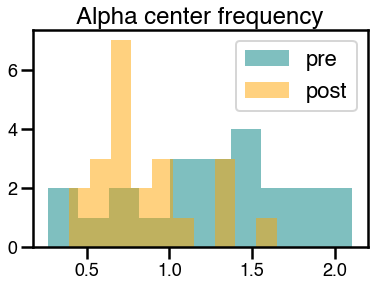

In [45]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [46]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   30.0   two-sided  0.000941  0.762846  0.752066
               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  3.871583   21   two-sided  0.000883  [0.18, 0.61]  0.940913  39.918   

           power  
T-test  0.987576  


### Alpha bandpower: pre/post

**Normality**

In [47]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.976025  0.844008    True
          W      pval  normal
0  0.975851  0.840472    True


#### Distribution of means pre vs. post

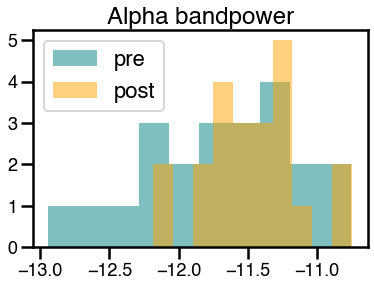

In [48]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha bandpower')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [49]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   60.0   two-sided  0.030118 -0.525692  0.386364
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.310885   21   two-sided  0.031085  [-0.43, -0.02]  0.472074  1.959   

           power  
T-test  0.560591  


### Alpha Bandwidth pre/post

**Normality**

In [50]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bw'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bw'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.889578  0.018495   False
          W      pval  normal
0  0.928232  0.112717    True


#### Distribution of means pre vs. post

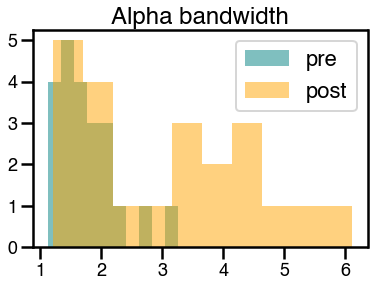

In [51]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha bandwidth')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [52]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   25.0   two-sided  0.000428 -0.802372  0.252066
               T  dof alternative     p-val          CI95%   cohen-d    BF10  \
T-test -4.243232   21   two-sided  0.000363  [-1.9, -0.65]  1.155591  87.168   

           power  
T-test  0.999311  


### Alpha center frequency: pre/post

**Normality**

In [53]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.961595  0.522192    True
          W      pval  normal
0  0.962009  0.530941    True


#### Distribution of means pre vs. post

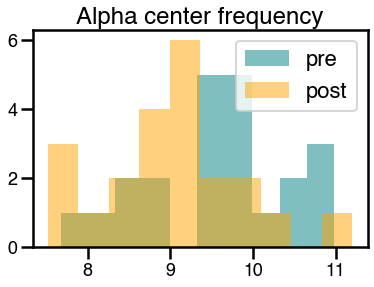

In [54]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon + T-Test**

Using Wilcoxon due to some distributions not being normal.

In [55]:
print(wilcoxon(means_pre, means_post))
print(ttest(means_pre, means_post, paired=True))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   26.0   two-sided  0.000504  0.794466  0.698347
               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  4.189186   21   two-sided  0.000413  [0.29, 0.87]  0.665777  77.764   

           power  
T-test  0.845482  


## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta/theta/alpha oscillation per participant, per pre/post

#### Delta Percentage

In [56]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [57]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [58]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

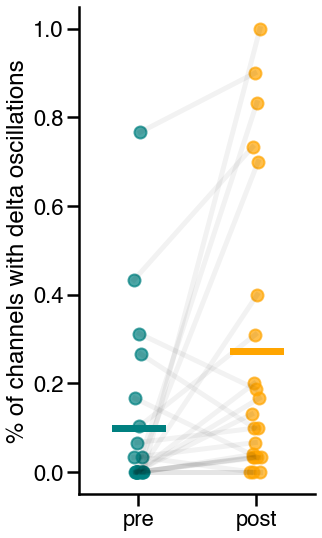

In [59]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylabel('% of channels with delta oscillations')
plt.tight_layout()
sns.despine()
plt.show()

In [60]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

print(ttest(perc_delta_pre, perc_delta_post, paired=True))

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.647419   21   two-sided  0.015062  [-0.31, -0.04]  0.641583  3.539   

           power  
T-test  0.818401  


#### Theta Percentage

In [61]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [62]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [63]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

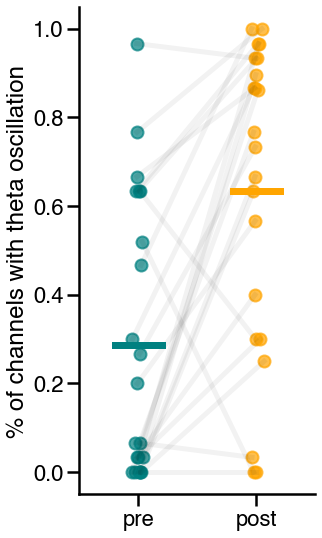

In [64]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('% of channels with theta oscillation')
sns.despine()
plt.tight_layout()
plt.show()

In [65]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

print(ttest(perc_theta_pre, perc_theta_post, paired=True))

               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -4.318628   21   two-sided  0.000303  [-0.52, -0.18]  1.051827   

           BF10     power  
T-test  102.241  0.996905  


#### Alpha Percentage

In [66]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [67]:
exp_df_alpha_osc[exp_df_alpha_osc['patient']==19]['channel'].count()

32

In [68]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [69]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

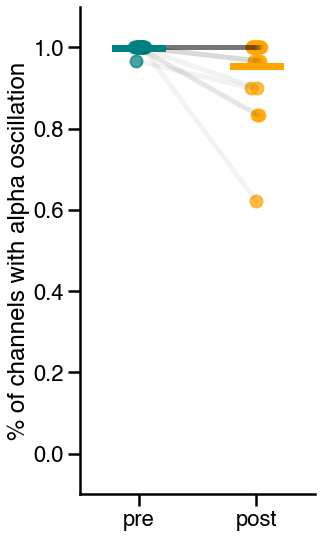

In [70]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('% of channels with alpha oscillation')
plt.ylim([-0.1,1.1])
sns.despine()
plt.tight_layout()
plt.show()

In [71]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

print(ttest(perc_alpha_pre, perc_alpha_post, paired=True))

               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.296271   21   two-sided  0.032052  [0.0, 0.08]  0.685287  1.912   

           power  
T-test  0.865267  


In [72]:
# combine all dataframes for mega dataframe with all features + osc percentages

delta_theta_merge = pd.merge(delta_osc_perc, theta_osc_perc, on=['patient', 'pre_post'], how='outer')


In [73]:
delta_theta_alpha_merge = pd.merge(delta_theta_merge, alpha_osc_perc, on=['patient', 'pre_post'], how='outer')

In [74]:
ols_df = pd.merge(exp_df_included, delta_theta_alpha_merge, on=['patient', 'pre_post'], how='outer')

In [75]:
ols_df

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,...,exponent,error,r_squared,exclude,delta_present,ch_delta_perc,theta_present,ch_theta_perc,alpha_present,ch_alpha_perc
0,3,pre,FP1,NaN,NaN,NaN,-12.267606,6.962120,1.000000,0.305205,...,0.263405,0.034298,0.963706,False,8,0.266667,19,0.633333,30,1.0
1,3,pre,FPZ,NaN,NaN,NaN,-12.272245,6.964903,1.000000,0.304622,...,0.253555,0.033938,0.964036,False,8,0.266667,19,0.633333,30,1.0
2,3,pre,FP2,NaN,NaN,NaN,-12.249414,6.940363,1.000000,0.241165,...,0.248060,0.035731,0.956344,False,8,0.266667,19,0.633333,30,1.0
3,3,pre,AF3,NaN,NaN,NaN,-12.065961,6.975710,1.000000,0.279689,...,0.311218,0.034778,0.947780,False,8,0.266667,19,0.633333,30,1.0
4,3,pre,AF4,NaN,NaN,NaN,-12.066338,6.915939,1.000000,0.266846,...,0.268926,0.030768,0.953309,False,8,0.266667,19,0.633333,30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,55,post,C1,NaN,NaN,NaN,-10.428589,4.407758,2.783407,0.770144,...,2.244894,0.121829,0.976433,False,12,0.400000,26,0.866667,30,1.0
1260,55,post,CZ,2.727103,1.016077,0.604080,-10.360934,5.058219,1.785028,0.902219,...,2.220334,0.093044,0.985013,False,12,0.400000,26,0.866667,30,1.0
1261,55,post,C2,NaN,NaN,NaN,-10.417643,4.324318,2.721091,0.806636,...,2.298567,0.129044,0.975367,False,12,0.400000,26,0.866667,30,1.0
1262,55,post,C4,3.872480,2.540675,0.850011,-10.307605,NaN,NaN,NaN,...,2.209323,0.107036,0.981238,False,12,0.400000,26,0.866667,30,1.0


## Multiple Regression Analysis of Band Power

### Overall for pre & post

In [76]:
model = ols('delta_bp ~ exponent + offset + delta_amp', exp_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1325.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           8.80e-27
Time:                        15:46:12   Log-Likelihood:                 40.656
No. Observations:                  28   AIC:                            -73.31
Df Residuals:                      24   BIC:                            -67.98
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7816      0.581     -1.345      0.1

In [77]:
model = ols('theta_bp ~ exponent + offset + theta_amp', exp_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     575.2
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           6.68e-28
Time:                        15:46:12   Log-Likelihood:                 35.609
No. Observations:                  36   AIC:                            -63.22
Df Residuals:                      32   BIC:                            -56.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1958      0.751     -0.261      0.7

In [78]:
model = ols('alpha_bp ~ exponent + offset + alpha_amp', exp_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     382.6
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           1.78e-29
Time:                        15:46:12   Log-Likelihood:                 44.533
No. Observations:                  44   AIC:                            -81.07
Df Residuals:                      40   BIC:                            -73.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2687      0.672      1.887      0.0

### Difference after treatment intervention

In [79]:
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf']

diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
diff_df_mean['patient'] = exp_df_mean['patient']

/var/folders/y7/q610k5y915x9bbdk7w61kb9c0000gn/T/ipykernel_10796/380126221.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [80]:
model = ols('delta_bp ~ exponent + offset + delta_amp', diff_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     210.5
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           7.41e-05
Time:                        15:46:12   Log-Likelihood:                 12.744
No. Observations:                   8   AIC:                            -17.49
Df Residuals:                       4   BIC:                            -17.17
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0112      0.049      0.227      0.8

/Users/quirine/opt/anaconda3/envs/ECT_Hadas/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [81]:
model = ols('theta_bp ~ exponent + offset + theta_amp', diff_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     73.44
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           1.47e-07
Time:                        15:46:12   Log-Likelihood:                 13.602
No. Observations:                  15   AIC:                            -19.20
Df Residuals:                      11   BIC:                            -16.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1294      0.079     -1.641      0.1

/Users/quirine/opt/anaconda3/envs/ECT_Hadas/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [82]:
model = ols('alpha_bp ~ exponent + offset + alpha_amp', diff_df_mean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     149.5
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           6.55e-13
Time:                        15:46:12   Log-Likelihood:                 22.335
No. Observations:                  22   AIC:                            -36.67
Df Residuals:                      18   BIC:                            -32.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0539      0.048     -1.114      0.2